In [1]:
#import libraries
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
data = pd.read_csv('mean-relative-humidity-Japanweather1.csv') #load the dataset

In [3]:
# to explicitly convert the date column to type DATETIME
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.dtypes

date                            datetime64[ns]
total_precipitation                    float64
mean_wind_speed                        float64
mean_air_temperature                   float64
percentage_possible_sunshine           float64
total_sunshine_duration                float64
solar_radiation                        float64
mean_relative_humidity                 float64
dtype: object

In [4]:
data = data.set_index('date') #set the index of the dataset as the date

In [5]:
data_mean_relative_humidity = data[['mean_relative_humidity']] # creating new dataframe from mean_relative_humidity column
data_mean_relative_humidity.loc[:,'last_month'] = data_mean_relative_humidity.loc[:,'mean_relative_humidity'].shift() # inserting new column with last month's mean_relative_humidity values
data_mean_relative_humidity = data_mean_relative_humidity.dropna() # dropping NAs
data_mean_relative_humidity

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,mean_relative_humidity,last_month
date,,
2010-02-01,77.0,67.0
2010-03-01,71.0,77.0
2010-04-01,76.0,71.0
2010-05-01,79.0,76.0
2010-06-01,82.0,79.0
...,...,...
2022-07-01,72.4,75.2
2022-08-01,73.0,72.4
2022-09-01,74.6,73.0


In [6]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [7]:
X_train = data_mean_relative_humidity.drop(['mean_relative_humidity'], axis = 1)
y_train = data_mean_relative_humidity.loc[:'2022', 'mean_relative_humidity']

In [8]:
X_train

,last_month
date,
2010-02-01,67.0
2010-03-01,77.0
2010-04-01,71.0
2010-05-01,76.0
2010-06-01,79.0
...,...
2022-07-01,75.2
2022-08-01,72.4
2022-09-01,73.0


In [9]:
y_train

date
2010-02-01    77.0
2010-03-01    71.0
2010-04-01    76.0
2010-05-01    79.0
2010-06-01    82.0
              ... 
2022-07-01    72.4
2022-08-01    73.0
2022-09-01    74.6
2022-10-01    75.1
2022-11-01    73.7
Name: mean_relative_humidity, Length: 142, dtype: float64

In [10]:
test_data = pd.read_csv('predicted-mean-relative-humidity.csv')
test_data = test_data.set_index('date')
X_test = test_data.drop(['mean_relative_humidity'], axis = 1)
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_model = gsearch.best_estimator_
y_pred = best_model.predict(X_test)
print(y_pred)

[75.94610709]


In [15]:
predicted_data = pd.read_csv('predicted-mean-relative-humidity.csv')
predicted_data.head()

,date,last_month,mean_relative_humidity
0,Jan-22,NaN,72.8
1,Feb-22,NaN,74.5
2,Mar-22,NaN,75.2
3,Apr-22,NaN,73.1
4,May-22,NaN,74.2


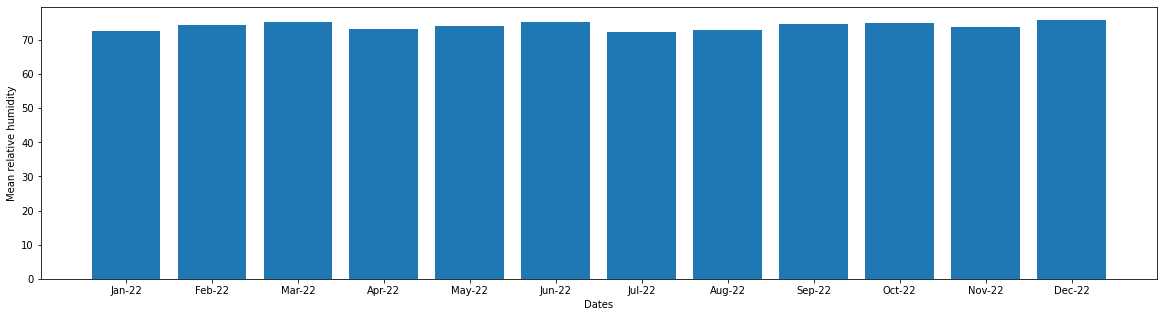

In [16]:
fig = plt.figure() # create an empty figure
plt.bar(predicted_data['date'], predicted_data['mean_relative_humidity']) #set the dates as the x-axis and the predicted-mean-relative-humidity as the y-axis
plt.ylabel("Mean relative humidity") # set the label for the y-axis
plt.xlabel("Dates") # set the label for the x-axis
fig.set_size_inches(20, 5) #set the size of the figure
plt.show()